In [1]:
# specify train, validation and test path 
train_dir = '/content/drive/MyDrive/MyProjects/garbage_img_classification/data/train'
val_dir = '/content/drive/MyDrive/MyProjects/garbage_img_classification/data/val'
test_dir = '/content/drive/MyDrive/MyProjects/garbage_img_classification/data/test'

# specify project directory in google drive
project_dir = '/content/drive/MyDrive/MyProjects/garbage_img_classification/'

# model name
model_name = 'best_cnn.h5'

# Garbage Image Classification

## Objective 
To classify type of garbage in an image.  
This dataset contains 6 types of garbage;  
- cardboard (393 images)  
- glass (491 images)  
- metal (400 images)  
- paper (584 images)  
- plastic (472 images)  
- trash (127 images)

## Dataset
source : https://www.kaggle.com/asdasdasasdas/garbage-classification

## Approach
Baseline model : simple CNN model

## Create Image Data Generator (without data augmentation)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


## F-beta score function

In [3]:
from tensorflow.keras import backend

# optional sklearn.metrics.fbeta_score (cannot be used as training metric)
#from sklearn.metrics import fbeta_score

In [4]:
# I create F-beta score calculation in Keras to use as a metric 
# during training process instead of accuracy.

def fbeta(y_true, y_pred, beta=2):
  # clip predictions
  y_pred = backend.clip(y_pred, 0, 1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta, averaged across each class
  bb = beta ** 2
  fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
  return fbeta_score

## Baseline model : simple CNN model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               13107300  
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 13,108,802
Trainable params: 13,108,802
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    epochs=50)

Epoch 1/50
89/89 [==============================] - 11s 95ms/step - loss: 12.8857 - fbeta: 0.2272 - val_loss: 1.4814 - val_fbeta: 0.3132
Epoch 2/50
89/89 [==============================] - 8s 92ms/step - loss: 1.2187 - fbeta: 0.4158 - val_loss: 2.0232 - val_fbeta: 0.3868
Epoch 3/50
89/89 [==============================] - 8s 89ms/step - loss: 0.8530 - fbeta: 0.5690 - val_loss: 1.5661 - val_fbeta: 0.3809
Epoch 4/50
89/89 [==============================] - 8s 91ms/step - loss: 0.5309 - fbeta: 0.7439 - val_loss: 1.4716 - val_fbeta: 0.4441
Epoch 5/50
89/89 [==============================] - 8s 91ms/step - loss: 0.3608 - fbeta: 0.8314 - val_loss: 1.4666 - val_fbeta: 0.4279
Epoch 6/50
89/89 [==============================] - 8s 90ms/step - loss: 0.2821 - fbeta: 0.8749 - val_loss: 1.5780 - val_fbeta: 0.4250
Epoch 7/50
89/89 [==============================] - 8s 90ms/step - loss: 0.1923 - fbeta: 0.9275 - val_loss: 1.7994 - val_fbeta: 0.4721
Epoch 8/50
89/89 [==============================] - 8

In [ ]:
# create function for plotting

def evaluate_model(history):
    # plot training and validation loss
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(121)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    plt.title('Loss')

    # plot training and validation accuracy
    fig.add_subplot(122)
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='val')
    plt.legend()
    plt.title('F-beta score')
    
    plt.show()
    
    # print model accuracy
    _, fbeta = model.evaluate(test_iter, steps=len(test_iter), verbose=0)
    print('Model F-beta score : ', fbeta)
    return fbeta

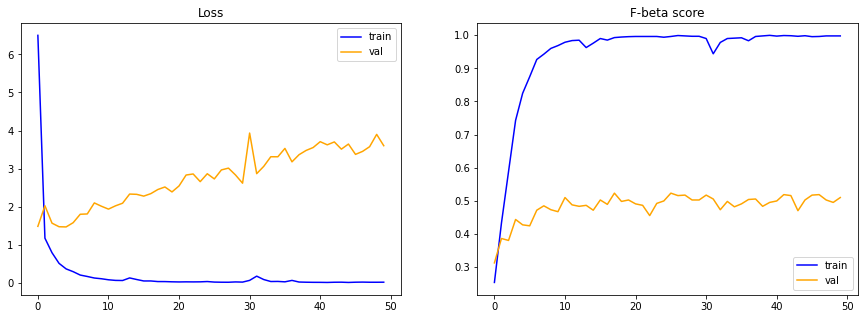

Model F-beta score :  0.5104408264160156


In [ ]:
baseline_performance = evaluate_model(history)

Note : overfitting

Try
- adding dropout layers
- data augmentation

## Improved Models

### model 1 : Baseline model + dropout layers

Epoch 1/50
89/89 [==============================] - 9s 97ms/step - loss: 24.4797 - fbeta: 0.1354 - val_loss: 1.7854 - val_fbeta: 0.0000e+00
Epoch 2/50
89/89 [==============================] - 8s 92ms/step - loss: 1.7833 - fbeta: 0.0000e+00 - val_loss: 1.7745 - val_fbeta: 0.0000e+00
Epoch 3/50
89/89 [==============================] - 8s 91ms/step - loss: 1.7745 - fbeta: 0.0000e+00 - val_loss: 1.7650 - val_fbeta: 0.0000e+00
Epoch 4/50
89/89 [==============================] - 8s 91ms/step - loss: 1.7624 - fbeta: 0.0000e+00 - val_loss: 1.7566 - val_fbeta: 0.0000e+00
Epoch 5/50
89/89 [==============================] - 8s 93ms/step - loss: 1.7578 - fbeta: 0.0000e+00 - val_loss: 1.7498 - val_fbeta: 0.0000e+00
Epoch 6/50
89/89 [==============================] - 8s 92ms/step - loss: 1.7488 - fbeta: 0.0000e+00 - val_loss: 1.7442 - val_fbeta: 0.0000e+00
Epoch 7/50
89/89 [==============================] - 8s 91ms/step - loss: 1.7443 - fbeta: 0.0000e+00 - val_loss: 1.7394 - val_fbeta: 0.0000e+00
Ep

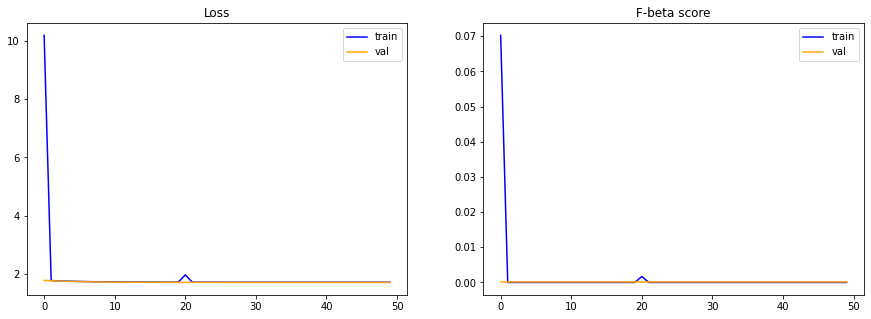

Model F-beta score :  0.0


In [ ]:
# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    epochs=50)

# plot result
model1_performance = evaluate_model(history)

Note : the loss reduced very slowly

### model 2 : Baseline model + Data Augmentation

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/100
89/89 [==============================] - 14s 151ms/step - loss: 18.2697 - fbeta: 0.2491 - val_loss: 1.7990 - val_fbeta: 0.2485
Epoch 2/100
89/89 [==============================] - 13s 151ms/step - loss: 1.5711 - fbeta: 0.2559 - val_loss: 1.5073 - val_fbeta: 0.3059
Epoch 3/100
89/89 [==============================] - 14s 153ms/step - loss: 1.6006 - fbeta: 0.2866 - val_loss: 1.4677 - val_fbeta: 0.3250
Epoch 4/100
89/89 [==============================] - 13s 149ms/step - loss: 1.3962 - fbeta: 0.2866 - val_loss: 1.4658 - val_fbeta: 0.3338
Epoch 5/100
89/89 [==============================] - 13s 148ms/step - loss: 1.2849 - fbeta: 0.2840 - val_loss: 1.4013 - val_fbeta: 0.3412
Epoch 6/100
89/89 [==============================] - 13s 149ms/step - loss: 1.1888 - fbeta: 0.3147 - val_loss: 1.3658 - val_fbeta: 0.3809
Epoch 7/100
89/89 [============================

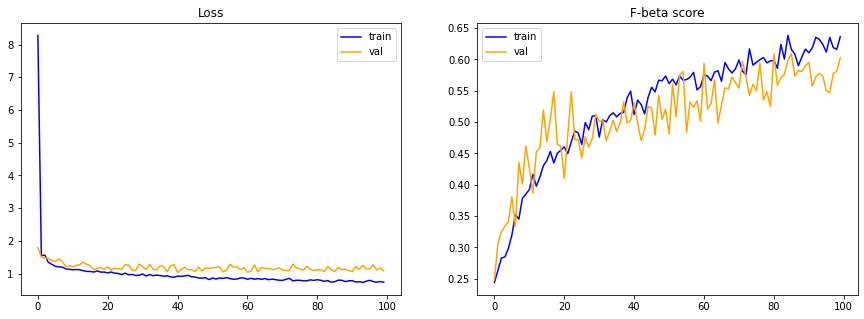

Model F-beta score :  0.612528920173645


In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    epochs=100)
# plot result
model2_performance = evaluate_model(history)

Note : overfitting is reduced, the performance need to be improved

### model 3 : Baseline model + data augmentation + dropout layers

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/100
89/89 [==============================] - 14s 151ms/step - loss: 13.4351 - fbeta: 0.0947 - val_loss: 1.7843 - val_fbeta: 0.0000e+00
Epoch 2/100
89/89 [==============================] - 13s 151ms/step - loss: 1.8506 - fbeta: 0.0062 - val_loss: 1.7738 - val_fbeta: 0.0000e+00
Epoch 3/100
89/89 [==============================] - 13s 150ms/step - loss: 1.7725 - fbeta: 0.0000e+00 - val_loss: 1.7646 - val_fbeta: 0.0000e+00
Epoch 4/100
89/89 [==============================] - 13s 150ms/step - loss: 1.7631 - fbeta: 3.1643e-05 - val_loss: 1.7572 - val_fbeta: 0.0000e+00
Epoch 5/100
89/89 [==============================] - 13s 149ms/step - loss: 1.7546 - fbeta: 0.0026 - val_loss: 1.7496 - val_fbeta: 0.0000e+00
Epoch 6/100
89/89 [==============================] - 13s 150ms/step - loss: 1.7502 - fbeta: 0.0000e+00 - val_loss: 1.7438 - val_fbeta: 0.0000e+00
Epoch 7/100

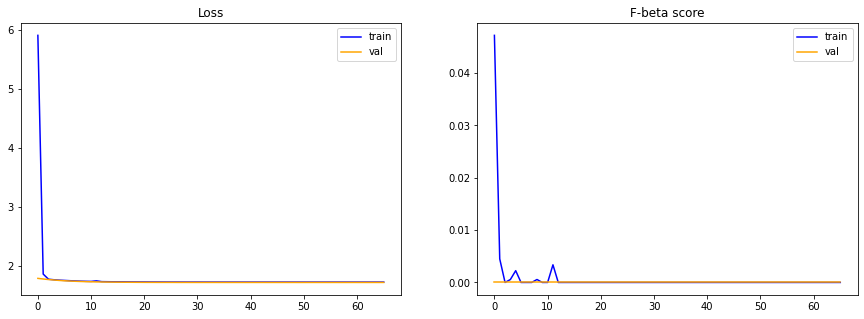

Model F-beta score :  0.0


In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# plot result
model3_performance = evaluate_model(history)

Note : again, dropout doesn't help

### model 4 : Baseline model + one more convolutional layer

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/200
89/89 [==============================] - 9s 94ms/step - loss: 5.4490 - fbeta: 0.1467 - val_loss: 1.3518 - val_fbeta: 0.2441
Epoch 2/200
89/89 [==============================] - 8s 91ms/step - loss: 1.0257 - fbeta: 0.4028 - val_loss: 1.3152 - val_fbeta: 0.3794
Epoch 3/200
89/89 [==============================] - 8s 91ms/step - loss: 0.6773 - fbeta: 0.6399 - val_loss: 1.3421 - val_fbeta: 0.4338
Epoch 4/200
89/89 [==============================] - 8s 90ms/step - loss: 0.4193 - fbeta: 0.7847 - val_loss: 1.7054 - val_fbeta: 0.4588
Epoch 5/200
89/89 [==============================] - 8s 92ms/step - loss: 0.2461 - fbeta: 0.8791 - val_loss: 1.7851 - val_fbeta: 0.4912
Epoch 6/200
89/89 [==============================] - 8s 91ms/step - loss: 0.1941 - fbeta: 0.9168 - val_loss: 1.8494 - val_fbeta: 0.5500
Epoch 7/200
89/89 [==============================] - 8s 92ms

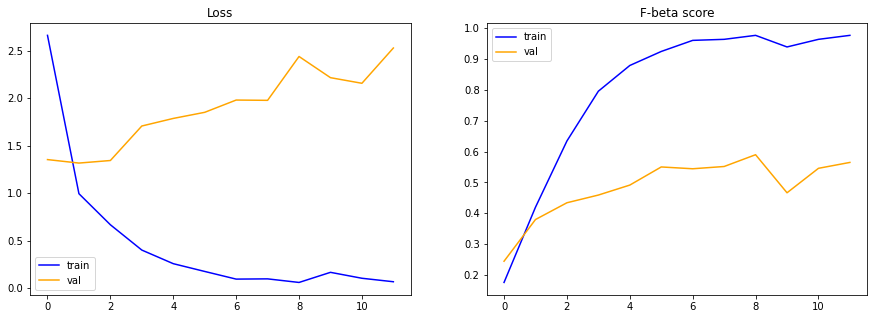

Model F-beta score :  0.5730857849121094


In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=200)

# plot result
model4_performance = evaluate_model(history)

Note : overfitting

### Improved model 5 : Baseline model + data augmentation + one more convolutional layer

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/200
89/89 [==============================] - 14s 152ms/step - loss: 9.4008 - fbeta: 0.0720 - val_loss: 1.6121 - val_fbeta: 0.0735
Epoch 2/200
89/89 [==============================] - 13s 149ms/step - loss: 1.5382 - fbeta: 0.0926 - val_loss: 1.5504 - val_fbeta: 0.0956
Epoch 3/200
89/89 [==============================] - 13s 151ms/step - loss: 1.4538 - fbeta: 0.1244 - val_loss: 1.3935 - val_fbeta: 0.1824
Epoch 4/200
89/89 [==============================] - 13s 149ms/step - loss: 1.3656 - fbeta: 0.1702 - val_loss: 1.2886 - val_fbeta: 0.2676
Epoch 5/200
89/89 [==============================] - 13s 149ms/step - loss: 1.2872 - fbeta: 0.2376 - val_loss: 1.2746 - val_fbeta: 0.2853
Epoch 6/200
89/89 [==============================] - 13s 151ms/step - loss: 1.2656 - fbeta: 0.2667 - val_loss: 1.2288 - val_fbeta: 0.3368
Epoch 7/200
89/89 [=============================

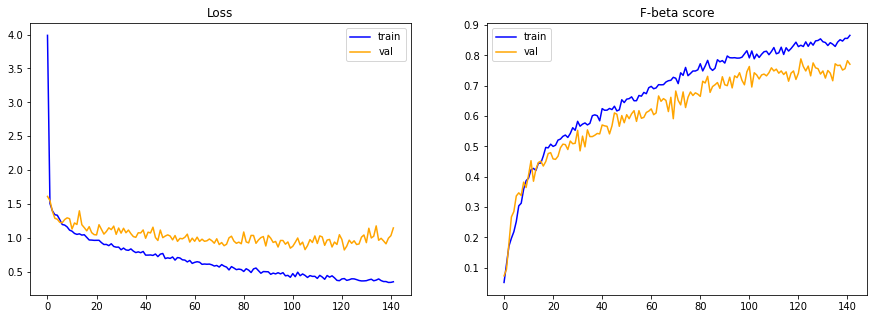

Model F-beta score :  0.761020839214325


In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=200)

# plot result
model5_performance = evaluate_model(history)

Note : there's small overfitting, the performance is higher

### Improved model 6 : Baseline + data augmentation + 2 more convolutional layers

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/200
89/89 [==============================] - 14s 153ms/step - loss: 3.4570 - fbeta: 0.0639 - val_loss: 1.5383 - val_fbeta: 0.0721
Epoch 2/200
89/89 [==============================] - 13s 150ms/step - loss: 1.4991 - fbeta: 0.1098 - val_loss: 1.4290 - val_fbeta: 0.1471
Epoch 3/200
89/89 [==============================] - 13s 151ms/step - loss: 1.3917 - fbeta: 0.1635 - val_loss: 1.5177 - val_fbeta: 0.2074
Epoch 4/200
89/89 [==============================] - 13s 150ms/step - loss: 1.3372 - fbeta: 0.1951 - val_loss: 1.4891 - val_fbeta: 0.2515
Epoch 5/200
89/89 [==============================] - 13s 151ms/step - loss: 1.2933 - fbeta: 0.2248 - val_loss: 1.3099 - val_fbeta: 0.3015
Epoch 6/200
89/89 [==============================] - 13s 152ms/step - loss: 1.2383 - fbeta: 0.2958 - val_loss: 1.2870 - val_fbeta: 0.2971
Epoch 7/200
89/89 [=============================

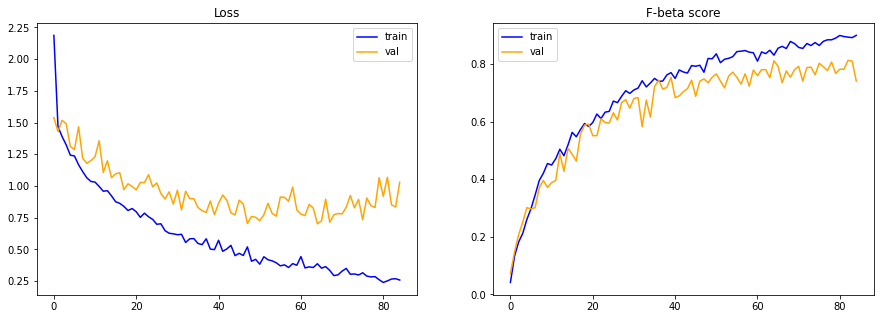

Model F-beta score :  0.7494198679924011


In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(200, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=200)

# plot result
model6_performance = evaluate_model(history)

Note : the performance is lower a little, there is overfitting

### Improved model 7 : Baseline model + data augmentation + 2 convolutional layers + one more dense layers

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/200
89/89 [==============================] - 14s 153ms/step - loss: 7.2009 - fbeta: 0.0778 - val_loss: 1.4448 - val_fbeta: 0.1044
Epoch 2/200
89/89 [==============================] - 14s 156ms/step - loss: 1.4373 - fbeta: 0.1404 - val_loss: 1.3597 - val_fbeta: 0.1676
Epoch 3/200
89/89 [==============================] - 13s 149ms/step - loss: 1.3776 - fbeta: 0.1629 - val_loss: 1.3723 - val_fbeta: 0.3015
Epoch 4/200
89/89 [==============================] - 13s 149ms/step - loss: 1.2793 - fbeta: 0.2467 - val_loss: 1.3693 - val_fbeta: 0.2721
Epoch 5/200
89/89 [==============================] - 13s 151ms/step - loss: 1.2408 - fbeta: 0.2830 - val_loss: 1.3605 - val_fbeta: 0.3029
Epoch 6/200
89/89 [==============================] - 13s 150ms/step - loss: 1.2850 - fbeta: 0.2627 - val_loss: 1.2719 - val_fbeta: 0.3324
Epoch 7/200
89/89 [=============================

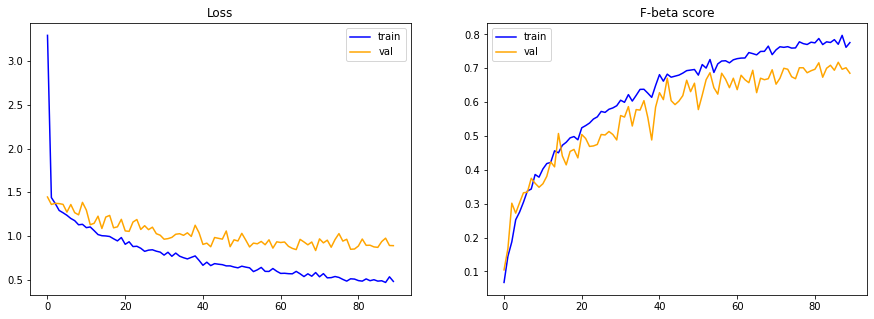

Model F-beta score :  0.6960555911064148


In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(50, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=200)

# plot result
model7_performance = evaluate_model(history)

Note : the performance is decreased, there is slight overfitting

### Learning result 

In [ ]:
print('Baseline : ', baseline_performance)
print('model 1 : ', model1_performance)
print('model 2 : ', model2_performance)
print('model 3 : ', model3_performance)
print('model 4 : ', model4_performance)
print('model 5 : ', model5_performance)
print('model 6 : ', model6_performance)
print('model 7 : ', model7_performance)

Baseline :  0.5104408264160156
model 1 :  0.0
model 2 :  0.612528920173645
model 3 :  0.0
model 4 :  0.5730857849121094
model 5 :  0.761020839214325
model 6 :  0.7494198679924011
model 7 :  0.6960555911064148


## Finalize the model
Train the selected model again.  
Give it more time to learn.  
Save the highest performance with ModelCheckpoint.

In [6]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical', shuffle=False)

# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy')

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# create model checkpoint
mc = ModelCheckpoint(model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es, mc],
                    epochs=300)

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/300
89/89 [==============================] - 863s 10s/step - loss: 12.6763 - val_loss: 1.6034

Epoch 00001: val_loss improved from inf to 1.60343, saving model to best_cnn.h5
Epoch 2/300
89/89 [==============================] - 14s 152ms/step - loss: 1.5557 - val_loss: 1.4449

Epoch 00002: val_loss improved from 1.60343 to 1.44487, saving model to best_cnn.h5
Epoch 3/300
89/89 [==============================] - 14s 153ms/step - loss: 1.4367 - val_loss: 1.3921

Epoch 00003: val_loss improved from 1.44487 to 1.39211, saving model to best_cnn.h5
Epoch 4/300
89/89 [==============================] - 14s 152ms/step - loss: 1.3557 - val_loss: 1.4255

Epoch 00004: val_loss did not improve from 1.39211
Epoch 5/300
89/89 [==============================] - 13s 151ms/step - loss: 1.2617 - val_loss: 1.4026

Epoch 00005: val_loss did not improve from 1.39211
Epoch 6/300

In [10]:
# get y_true
y_true = test_iter.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [26]:
# get one-hot encoded y_true 
from keras.utils import to_categorical
y_true_enc = to_categorical(y_true)
y_true_enc

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [48]:
# get y_pred
import numpy as np
prediction = model.predict(test_iter)
y_pred = np.rint(prediction)
y_pred

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [53]:
# print model score
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score
print('Confusion Matrix')
print(confusion_matrix(y_true_enc.argmax(axis=1), y_pred.argmax(axis=1)))
print('\nClassification Report')
print('\n', classification_report(y_true_enc.argmax(axis=1), y_pred.argmax(axis=1)))
print('\nmodel f2 score : ', fbeta_score(y_true_enc, y_pred, 2, average='samples'))

Confusion Matrix
[[60  1  3  3  2  1]
 [19 47  7  4  5  0]
 [ 8  5 45  4  6  0]
 [ 8  0  2 96  1  1]
 [10  1  3 11 49  0]
 [ 8  1  5  4  2  9]]

Classification Report

               precision    recall  f1-score   support

           0       0.53      0.86      0.66        70
           1       0.85      0.57      0.69        82
           2       0.69      0.66      0.68        68
           3       0.79      0.89      0.83       108
           4       0.75      0.66      0.71        74
           5       0.82      0.31      0.45        29

    accuracy                           0.71       431
   macro avg       0.74      0.66      0.67       431
weighted avg       0.74      0.71      0.70       431


model f2 score :  0.7076566125290024


In [54]:
!ls -la

total 77096
drwxr-xr-x 1 root root     4096 Jan 25 02:00 .
drwxr-xr-x 1 root root     4096 Jan 25 01:41 ..
-rw-r--r-- 1 root root 78925192 Jan 25 02:13 best_cnn.h5
drwxr-xr-x 1 root root     4096 Jan 20 17:27 .config
drwx------ 4 root root     4096 Jan 25 01:45 drive
drwxr-xr-x 1 root root     4096 Jan 20 17:27 sample_data


In [62]:
# copy saved model file to the project directory
import shutil

shutil.copyfile(model_name, project_dir+model_name)

'/content/drive/MyDrive/MyProjects/garbage_img_classification/best_cnn.h5'